### Station S3 Bloom Timing Analysis - Mixing Factors

This notebooks includes drivers related to mixing and stratification
* halocline depth 
* turbocline depth 
* average eddy diffusivity over upper 15m
* average eddy diffusivity over upper 15m
* density difference between the surface and a series of depths (5m increments to 30m)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, places, viz_tools, visualisations
import xarray as xr
import pandas as pd
import pickle
import os
import bloomdrivers
import seaborn as sns
import cmocean
import pylab
import gsw

%matplotlib inline

### To recreate this notebook at a different location, follow these instructions: 

In [2]:
# The path to the directory where the pickle files are stored:
savedir='/ocean/aisabell/MEOPAR/extracted_files'
# Change 'S3' to the location of interest
loc='S3'
# What is the start year and end year+1 of the time range of interest?
startyear=2007
endyear=2021 # does NOT include this value
# Note: What is the model run?

# Note: non-location specific variables only need to be done for each year, not for each location
# Note: xticks in the plots will need to be changed
# Note: 201812 bloom timing variable load and plotting will also need to be removed

In [3]:
start=dt.datetime(2015,1,1) # some date to get depth
end=dt.datetime(2015,1,2)
basedir='/results2/SalishSea/nowcast-green.201905/'
nam_fmt='nowcast'
flen=1 # files contain 1 day of data each
tres=24 # 1: hourly resolution; 24: daily resolution
flist=et.index_model_files(start,end,basedir,nam_fmt,flen,"grid_T",tres)
with xr.open_mfdataset(flist['paths']) as gridt:
    depth_T=np.array(gridt.deptht)

1.1363636363636362

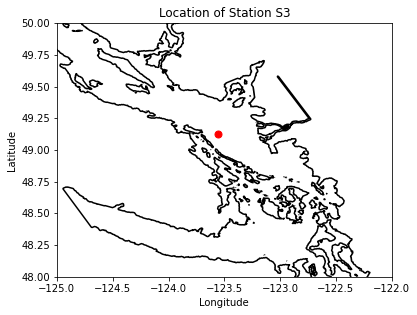

In [4]:
modver='201905'
# lat and lon information for place:
lon,lat=places.PLACES[loc]['lon lat']
# get place information on SalishSeaCast grid:
ij,ii=places.PLACES[loc]['NEMO grid ji']
jw,iw=places.PLACES[loc]['GEM2.5 grid ji']

fig, ax = plt.subplots(1,1,figsize = (6,6))
with xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc') as mesh:
    ax.contour(mesh.nav_lon,mesh.nav_lat,mesh.tmask.isel(t=0,z=0),[0.1,],colors='k')
    tmask=np.array(mesh.tmask)
    gdept_1d=np.array(mesh.gdept_1d)
    e3t_0=np.array(mesh.e3t_0)
ax.plot(lon, lat, '.', markersize=14, color='red')
ax.set_ylim(48,50)
ax.set_xlim(-125,-122)
ax.set_title('Location of Station %s'%loc)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
viz_tools.set_aspect(ax,coords='map')

### Load bloom timing variables for 201905 run

In [5]:
# loop through years of spring time series (mid feb-june) for bloom timing for 201905 run
years=list()
bloomtime1=list()
bloomtime2=list()
bloomtime3=list()
for year in range(startyear,endyear):
    fname3=f'springBloomTime_{str(year)}_{loc}_{modver}.pkl'
    savepath3=os.path.join(savedir,fname3)
    bio_time0,sno30,sdiat0,sflag0,scili0,diat_alld0,no3_alld0,flag_alld0,cili_alld0,phyto_alld0,\
                 intdiat0,intphyto0,fracdiat0,sphyto0,percdiat0=pickle.load(open(savepath3,'rb'))
    # put code that calculates bloom timing here
    bt1=bloomdrivers.metric1_bloomtime(phyto_alld0,no3_alld0,bio_time0)
    bt2=bloomdrivers.metric2_bloomtime(sphyto0,sno30,bio_time0)
    bt3=bloomdrivers.metric3_bloomtime(sphyto0,sno30,bio_time0)
    years.append(year)
    bloomtime1.append(bt1)
    bloomtime2.append(bt2)
    bloomtime3.append(bt3)   
years=np.array(years)
bloomtime1=np.array(bloomtime1)
bloomtime2=np.array(bloomtime2)
bloomtime3=np.array(bloomtime3)

# get year day
yearday1=et.datetimeToYD(bloomtime1)  # convert to year day tool
yearday2=et.datetimeToYD(bloomtime2)
yearday3=et.datetimeToYD(bloomtime3)

### Load mixing variables

In [6]:
# loop through years (for mixing drivers)

halojan=list()
halofeb=list()
halomar=list()
turbojan=list()
turbofeb=list()
turbomar=list()
densdiff5jan=list()
densdiff10jan=list()
densdiff15jan=list()
densdiff20jan=list()
densdiff25jan=list()
densdiff30jan=list()
densdiff5feb=list()
densdiff10feb=list()
densdiff15feb=list()
densdiff20feb=list()
densdiff25feb=list()
densdiff30feb=list()
densdiff5mar=list()
densdiff10mar=list()
densdiff15mar=list()
densdiff20mar=list()
densdiff25mar=list()
densdiff30mar=list()
eddy15jan=list()
eddy15feb=list()
eddy15mar=list()
eddy30jan=list()
eddy30feb=list()
eddy30mar=list()

for year in range(startyear,endyear):
    fname4=f'JanToMarch_Mixing_{year}_{loc}_{modver}.pkl'
    savepath4=os.path.join(savedir,fname4)
    halocline,eddy,depth,grid_time,temp,salinity=pickle.load(open(savepath4,'rb'))
   
    # halocline
    halo=bloomdrivers.janfebmar_halocline(grid_time,halocline)
    halojan.append(halo[0])
    halofeb.append(halo[1])
    halomar.append(halo[2])
    # turbocline
    turbo=bloomdrivers.turbo(eddy,grid_time,depth_T)
    turbojan.append(turbo[0])
    turbofeb.append(turbo[1])
    turbomar.append(turbo[2])
    # density differences
    dict_diffs=bloomdrivers.density_diff(salinity,temp,grid_time)
    values=dict_diffs.values()
    all_diffs=list(values)
    densdiff5jan.append(all_diffs[0])
    densdiff10jan.append(all_diffs[3])
    densdiff15jan.append(all_diffs[6])
    densdiff20jan.append(all_diffs[9])
    densdiff25jan.append(all_diffs[12])
    densdiff30jan.append(all_diffs[15])
    densdiff5feb.append(all_diffs[1])
    densdiff10feb.append(all_diffs[4])
    densdiff15feb.append(all_diffs[7])
    densdiff20feb.append(all_diffs[10])
    densdiff25feb.append(all_diffs[13])
    densdiff30feb.append(all_diffs[16])
    densdiff5mar.append(all_diffs[2])
    densdiff10mar.append(all_diffs[5])
    densdiff15mar.append(all_diffs[8])
    densdiff20mar.append(all_diffs[11])
    densdiff25mar.append(all_diffs[14])
    densdiff30mar.append(all_diffs[17])
    # average eddy diffusivity 
    avg_eddy=bloomdrivers.avg_eddy(eddy,grid_time,ij,ii)
    eddy15jan.append(avg_eddy[0])
    eddy15feb.append(avg_eddy[1])
    eddy15mar.append(avg_eddy[2])
    eddy30jan.append(avg_eddy[3])
    eddy30feb.append(avg_eddy[4])
    eddy30mar.append(avg_eddy[5])

halojan=np.array(halojan)
halofeb=np.array(halofeb)
halomar=np.array(halomar)
turbojan=np.array(turbojan)
turbofeb=np.array(turbofeb)
turbomar=np.array(turbomar)
densdiff5jan=np.array(densdiff5jan)
densdiff10jan=np.array(densdiff10jan)
densdiff15jan=np.array(densdiff15jan)
densdiff20jan=np.array(densdiff20jan)
densdiff25jan=np.array(densdiff25jan)
densdiff30jan=np.array(densdiff30jan)
densdiff5feb=np.array(densdiff5feb)
densdiff10feb=np.array(densdiff10feb)
densdiff15feb=np.array(densdiff15feb)
densdiff20feb=np.array(densdiff20feb)
densdiff25feb=np.array(densdiff25feb)
densdiff30feb=np.array(densdiff30feb)
densdiff5mar=np.array(densdiff5mar)
densdiff10mar=np.array(densdiff10mar)
densdiff15mar=np.array(densdiff15mar)
densdiff20mar=np.array(densdiff20mar)
densdiff25mar=np.array(densdiff25mar)
densdiff30mar=np.array(densdiff30mar)
eddy15jan=np.array(eddy15jan)
eddy15feb=np.array(eddy15feb)
eddy15mar=np.array(eddy15mar)
eddy30jan=np.array(eddy30jan)
eddy30feb=np.array(eddy30feb)
eddy30mar=np.array(eddy30mar)

### Bloom date

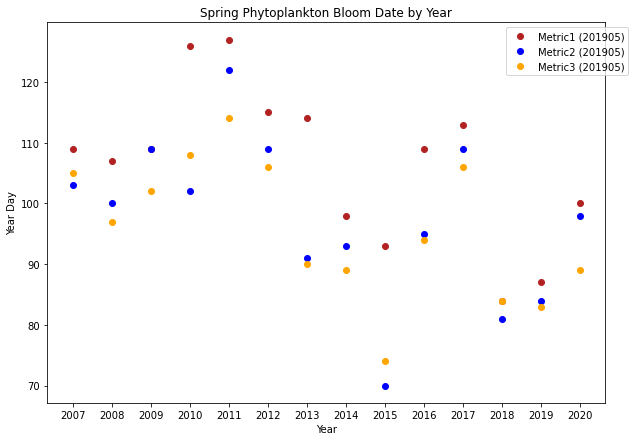

In [8]:
# plot bloomtime for each year: 
fig,ax=plt.subplots(1,1,figsize=(10,7))
p1=ax.plot(years,yearday1, 'o',color='firebrick',label='Metric1 (201905)')
p2=ax.plot(years,yearday2, 'o',color='b',label='Metric2 (201905)')
p3=ax.plot(years,yearday3, 'o',color='orange',label='Metric3 (201905)')

ax.set_ylabel('Year Day')
ax.set_xlabel('Year')
ax.set_title('Spring Phytoplankton Bloom Date by Year')
ax.set_xticks([2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020])
ax.legend(handles=[p1[0],p2[0],p3[0]],bbox_to_anchor=(1.05, 1.0))

### Halocline

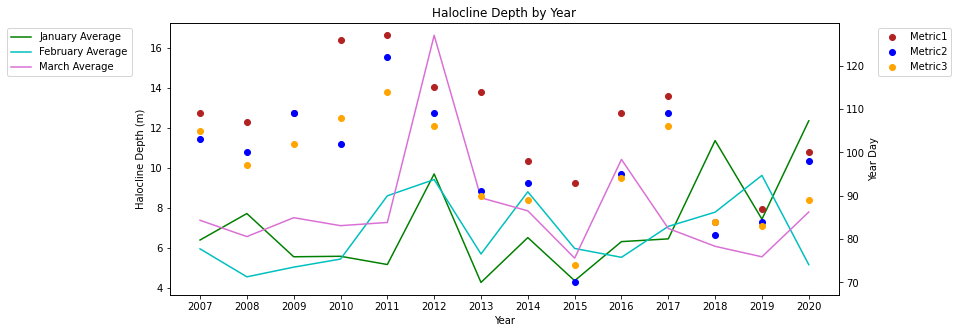

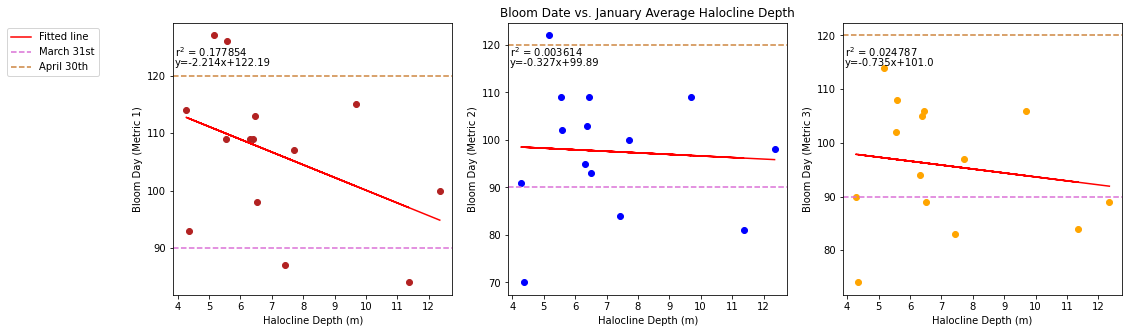

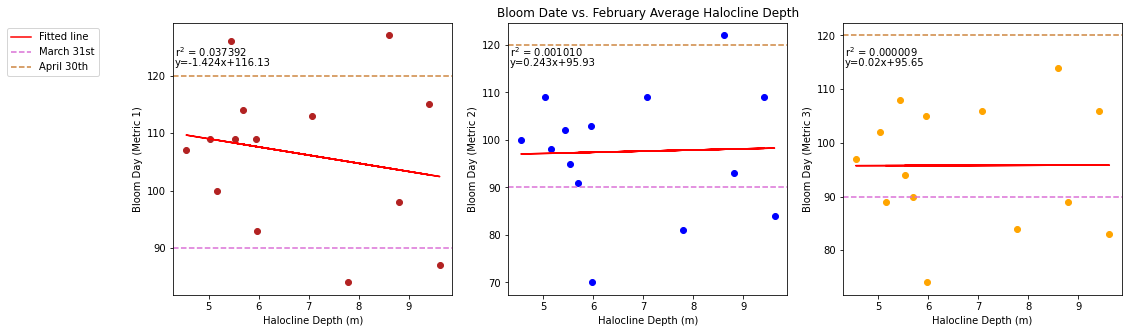

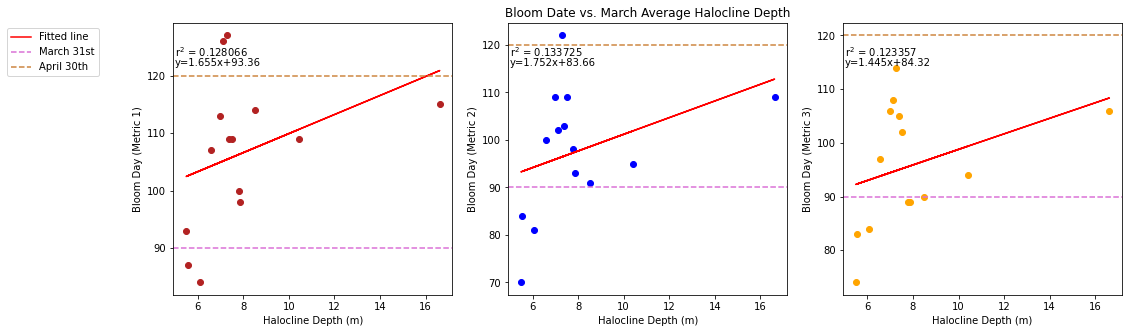

In [9]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
p1=ax.plot(years,halojan, '-',color='green',label='January Average')
p2=ax.plot(years,halofeb, '-',color='c',label='February Average')
p3=ax.plot(years,halomar, '-',color='orchid',label='March Average')
ax.set_ylabel('Halocline Depth (m)')
ax.set_xlabel('Year')
ax.set_title('Halocline Depth by Year')
ax.set_xticks([2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020])
ax.legend(handles=[p1[0],p2[0],p3[0]],bbox_to_anchor=(-0.25, 1.0), loc='upper left')

ax1=ax.twinx()
p4=ax1.plot(years,yearday1, 'o',color='firebrick',label='Metric1')
p5=ax1.plot(years,yearday2, 'o',color='b',label='Metric2')
p6=ax1.plot(years,yearday3, 'o',color='orange',label='Metric3')
ax1.set_ylabel('Year Day')
ax1.legend(handles=[p4[0],p5[0],p6[0]],bbox_to_anchor=(1.05, 1.0), loc='upper left')

# JAN
fig2,ax2=plt.subplots(1,3,figsize=(17,5))
ax2[0].plot(halojan,yearday1,'o',color='firebrick')
ax2[0].set_xlabel('Halocline Depth (m)')
ax2[0].set_ylabel('Bloom Day (Metric 1)')
y,r2,m,b=bloomdrivers.reg_r2(halojan,yearday1)
ax2[0].plot(halojan, y, 'r', label='Fitted line')
ax2[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax2[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax2[1].plot(halojan,yearday2,'o',color='b')
ax2[1].set_xlabel('Halocline Depth (m)')
ax2[1].set_ylabel('Bloom Day (Metric 2)')
y,r2,m,b=bloomdrivers.reg_r2(halojan,yearday2)
ax2[1].plot(halojan, y, 'r', label='Fitted line')
ax2[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax2[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax2[2].plot(halojan,yearday3,'o',color='orange')
ax2[2].set_xlabel('Halocline Depth (m)')
ax2[2].set_ylabel('Bloom Day (Metric 3)')
ax2[1].set_title('Bloom Date vs. January Average Halocline Depth')
y,r2,m,b=bloomdrivers.reg_r2(halojan,yearday3)
ax2[2].plot(halojan, y, 'r', label='Fitted line')
ax2[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax2[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

# FEB
fig3,ax3=plt.subplots(1,3,figsize=(17,5))
ax3[0].plot(halofeb,yearday1,'o',color='firebrick')
ax3[0].set_xlabel('Halocline Depth (m)')
ax3[0].set_ylabel('Bloom Day (Metric 1)')
y,r2,m,b=bloomdrivers.reg_r2(halofeb,yearday1)
ax3[0].plot(halofeb, y, 'r', label='Fitted line')
ax3[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax3[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax3[1].plot(halofeb,yearday2,'o',color='b')
ax3[1].set_xlabel('Halocline Depth (m)')
ax3[1].set_ylabel('Bloom Day (Metric 2)')
y,r2,m,b=bloomdrivers.reg_r2(halofeb,yearday2)
ax3[1].plot(halofeb, y, 'r', label='Fitted line')
ax3[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax3[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax3[2].plot(halofeb,yearday3,'o',color='orange')
ax3[2].set_xlabel('Halocline Depth (m)')
ax3[2].set_ylabel('Bloom Day (Metric 3)')
ax3[1].set_title('Bloom Date vs. February Average Halocline Depth')
y,r2,m,b=bloomdrivers.reg_r2(halofeb,yearday3)
ax3[2].plot(halofeb, y, 'r', label='Fitted line')
ax3[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax3[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

# MAR
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(halomar,yearday1,'o',color='firebrick')
ax4[0].set_xlabel('Halocline Depth (m)')
ax4[0].set_ylabel('Bloom Day (Metric 1)')
y,r2,m,b=bloomdrivers.reg_r2(halomar,yearday1)
ax4[0].plot(halomar, y, 'r', label='Fitted line')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(halomar,yearday2,'o',color='b')
ax4[1].set_xlabel('Halocline Depth (m)')
ax4[1].set_ylabel('Bloom Day (Metric 2)')
y,r2,m,b=bloomdrivers.reg_r2(halomar,yearday2)
ax4[1].plot(halomar, y, 'r', label='Fitted line')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(halomar,yearday3,'o',color='orange')
ax4[2].set_xlabel('Halocline Depth (m)')
ax4[2].set_ylabel('Bloom Day (Metric 3)')
ax4[1].set_title('Bloom Date vs. March Average Halocline Depth')
y,r2,m,b=bloomdrivers.reg_r2(halomar,yearday3)
ax4[2].plot(halomar, y, 'r', label='Fitted line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)


# Jan month lines
ax2[0].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax2[0].axhline(y=120, color='peru', linestyle='--',label='April 30th')
#ax2[0].axhline(y=151, color='lime', linestyle='--',label='May 31st')
ax2[0].legend(bbox_to_anchor=(-0.25, 1.0))
ax2[1].axhline(y=90, color='orchid', linestyle='--')
ax2[2].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax2[1].axhline(y=120, color='peru', linestyle='--')
ax2[2].axhline(y=120, color='peru', linestyle='--',label='April 30th')
# Feb month lines
ax3[0].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax3[0].axhline(y=120, color='peru', linestyle='--',label='April 30th')
#ax3[0].axhline(y=151, color='lime', linestyle='--',label='May 31st')
ax3[0].legend(bbox_to_anchor=(-0.25, 1.0))
ax3[1].axhline(y=90, color='orchid', linestyle='--')
ax3[2].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax3[1].axhline(y=120, color='peru', linestyle='--')
ax3[2].axhline(y=120, color='peru', linestyle='--',label='April 30th')
# March month lines
ax4[0].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax4[0].axhline(y=120, color='peru', linestyle='--',label='April 30th')
#ax4[0].axhline(y=151, color='lime', linestyle='--',label='May 31st')
ax4[0].legend(bbox_to_anchor=(-0.25, 1.0))
ax4[1].axhline(y=90, color='orchid', linestyle='--')
ax4[2].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax4[1].axhline(y=120, color='peru', linestyle='--')
ax4[2].axhline(y=120, color='peru', linestyle='--',label='April 30th')

### Monthly average turbocline depth (January-March)

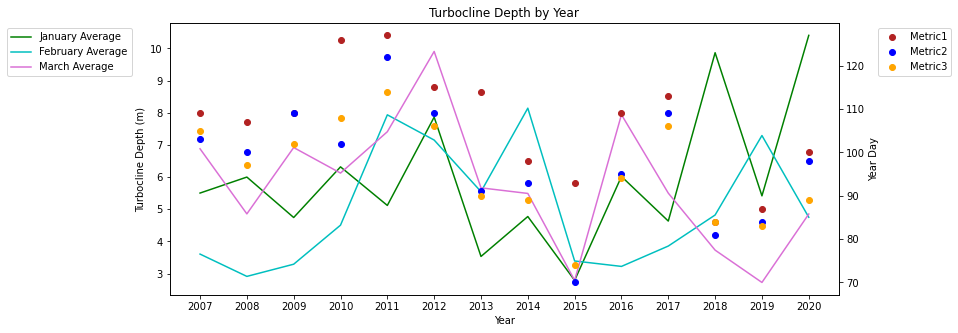

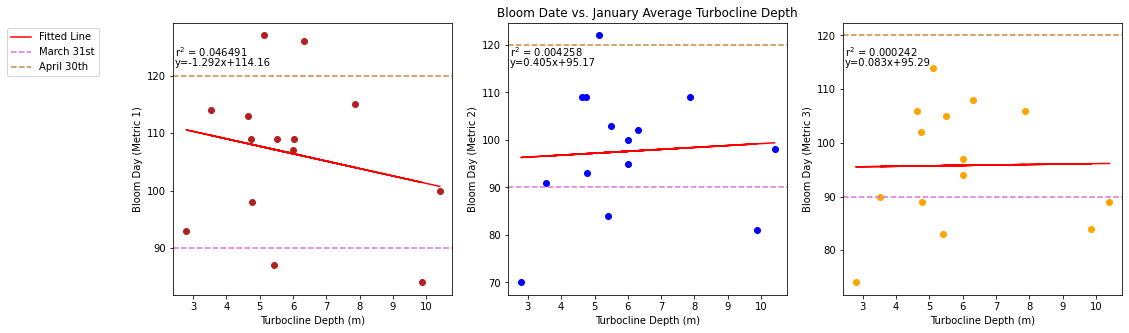

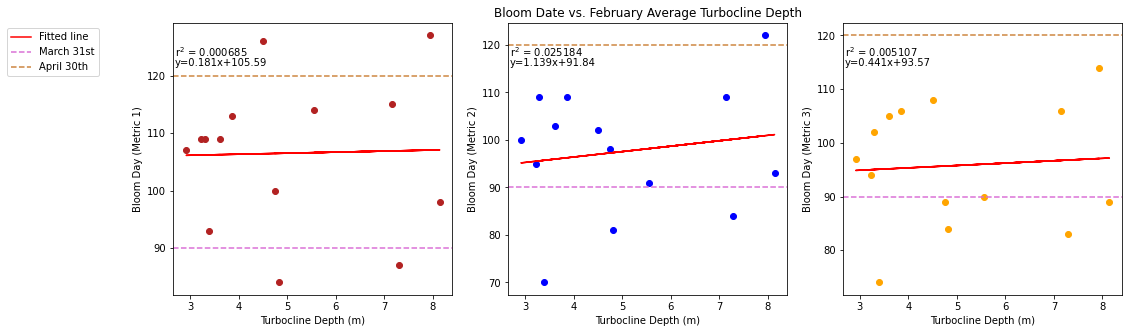

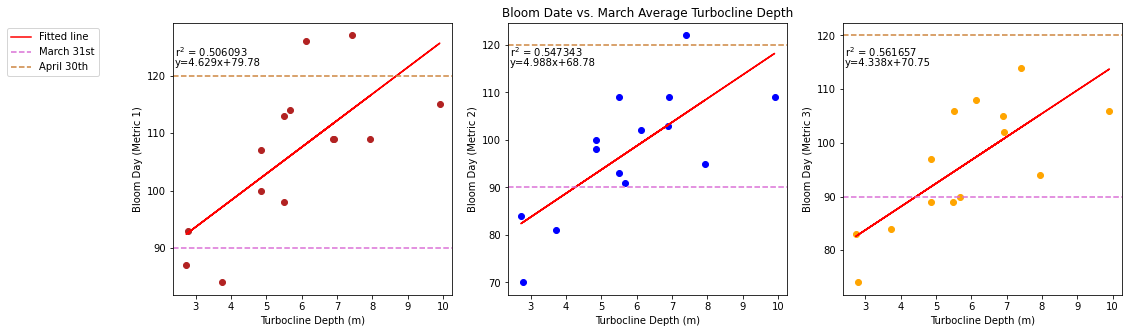

In [10]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
p1=ax.plot(years,turbojan, '-',color='green',label='January Average')
p2=ax.plot(years,turbofeb, '-',color='c',label='February Average')
p3=ax.plot(years,turbomar, '-',color='orchid',label='March Average')
ax.set_ylabel('Turbocline Depth (m)')
ax.set_xlabel('Year')
ax.set_title('Turbocline Depth by Year')
ax.set_xticks([2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020])
ax.legend(handles=[p1[0],p2[0],p3[0]],bbox_to_anchor=(-0.25, 1.0), loc='upper left')

ax1=ax.twinx()
p4=ax1.plot(years,yearday1, 'o',color='firebrick',label='Metric1')
p5=ax1.plot(years,yearday2, 'o',color='b',label='Metric2')
p6=ax1.plot(years,yearday3, 'o',color='orange',label='Metric3')
ax1.set_ylabel('Year Day')
ax1.legend(handles=[p4[0],p5[0],p6[0]],bbox_to_anchor=(1.05, 1.0), loc='upper left')

# ---------- Jan ---------
fig2,ax2=plt.subplots(1,3,figsize=(17,5))
ax2[0].plot(turbojan,yearday1,'o',color='firebrick')
ax2[0].set_xlabel('Turbocline Depth (m)')
ax2[0].set_ylabel('Bloom Day (Metric 1)')
y,r2,m,b=bloomdrivers.reg_r2(turbojan,yearday1)
ax2[0].plot(turbojan, y, 'r', label='Fitted Line')
ax2[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax2[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax2[1].plot(turbojan,yearday2,'o',color='b')
ax2[1].set_xlabel('Turbocline Depth (m)')
ax2[1].set_ylabel('Bloom Day (Metric 2)')
y,r2,m,b=bloomdrivers.reg_r2(turbojan,yearday2)
ax2[1].plot(turbojan, y, 'r', label='Fitted line')
ax2[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax2[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax2[2].plot(turbojan,yearday3,'o',color='orange')
ax2[2].set_xlabel('Turbocline Depth (m)')
ax2[2].set_ylabel('Bloom Day (Metric 3)')
y,r2,m,b=bloomdrivers.reg_r2(turbojan,yearday3)
ax2[2].plot(turbojan, y, 'r', label='Fitted line')
ax2[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax2[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax2[1].set_title('Bloom Date vs. January Average Turbocline Depth')

# ---------- Feb ---------
fig3,ax3=plt.subplots(1,3,figsize=(17,5))
ax3[0].plot(turbofeb,yearday1,'o',color='firebrick')
ax3[0].set_xlabel('Turbocline Depth (m)')
ax3[0].set_ylabel('Bloom Day (Metric 1)')
y,r2,m,b=bloomdrivers.reg_r2(turbofeb,yearday1)
ax3[0].plot(turbofeb, y, 'r', label='Fitted line')
ax3[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax3[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax3[1].plot(turbofeb,yearday2,'o',color='b')
ax3[1].set_xlabel('Turbocline Depth (m)')
ax3[1].set_ylabel('Bloom Day (Metric 2)')
y,r2,m,b=bloomdrivers.reg_r2(turbofeb,yearday2)
ax3[1].plot(turbofeb, y, 'r', label='Fitted line')
ax3[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax3[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax3[2].plot(turbofeb,yearday3,'o',color='orange')
ax3[2].set_xlabel('Turbocline Depth (m)')
ax3[2].set_ylabel('Bloom Day (Metric 3)')
y,r2,m,b=bloomdrivers.reg_r2(turbofeb,yearday3)
ax3[2].plot(turbofeb, y, 'r', label='Fitted line')
ax3[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax3[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax3[1].set_title('Bloom Date vs. February Average Turbocline Depth')

# ---------- March ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(turbomar,yearday1,'o',color='firebrick')
ax4[0].set_xlabel('Turbocline Depth (m)')
ax4[0].set_ylabel('Bloom Day (Metric 1)')
y,r2,m,b=bloomdrivers.reg_r2(turbomar,yearday1)
ax4[0].plot(turbomar, y, 'r', label='Fitted line')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(turbomar,yearday2,'o',color='b')
ax4[1].set_xlabel('Turbocline Depth (m)')
ax4[1].set_ylabel('Bloom Day (Metric 2)')
ax4[1].set_title('Bloom Date vs. March Average Turbocline Depth')
y,r2,m,b=bloomdrivers.reg_r2(turbomar,yearday2)
ax4[1].plot(turbomar, y, 'r', label='Fitted line')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(turbomar,yearday3,'o',color='orange')
ax4[2].set_xlabel('Turbocline Depth (m)')
ax4[2].set_ylabel('Bloom Day (Metric 3)')
y,r2,m,b=bloomdrivers.reg_r2(turbomar,yearday3)
ax4[2].plot(turbomar, y, 'r', label='Fitted line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

# Jan month lines
ax2[0].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax2[0].axhline(y=120, color='peru', linestyle='--',label='April 30th')
ax2[0].legend(bbox_to_anchor=(-0.25, 1.0))
ax2[1].axhline(y=90, color='orchid', linestyle='--')
ax2[2].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax2[1].axhline(y=120, color='peru', linestyle='--')
ax2[2].axhline(y=120, color='peru', linestyle='--',label='April 30th')
# Feb month lines
ax3[0].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax3[0].axhline(y=120, color='peru', linestyle='--',label='April 30th')
ax3[0].legend(bbox_to_anchor=(-0.25, 1.0))
ax3[1].axhline(y=90, color='orchid', linestyle='--')
ax3[2].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax3[1].axhline(y=120, color='peru', linestyle='--')
ax3[2].axhline(y=120, color='peru', linestyle='--',label='April 30th')
# March month lines
ax4[0].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax4[0].axhline(y=120, color='peru', linestyle='--',label='April 30th')
ax4[0].legend(bbox_to_anchor=(-0.25, 1.0))
ax4[1].axhline(y=90, color='orchid', linestyle='--')
ax4[2].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax4[1].axhline(y=120, color='peru', linestyle='--')
ax4[2].axhline(y=120, color='peru', linestyle='--',label='April 30th')

### Monthly average density difference from surface to 10m (January-March)

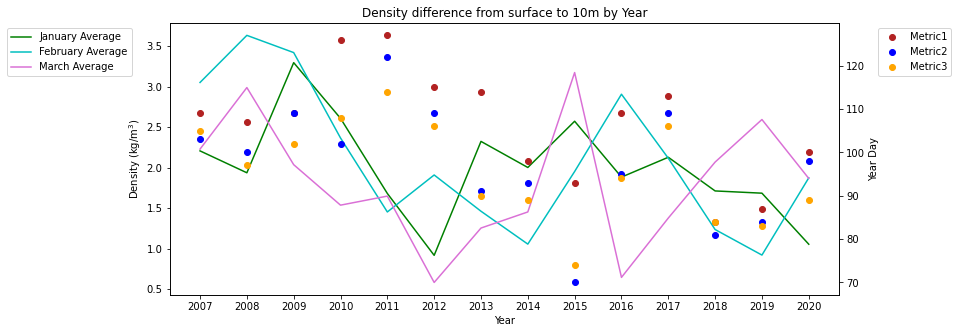

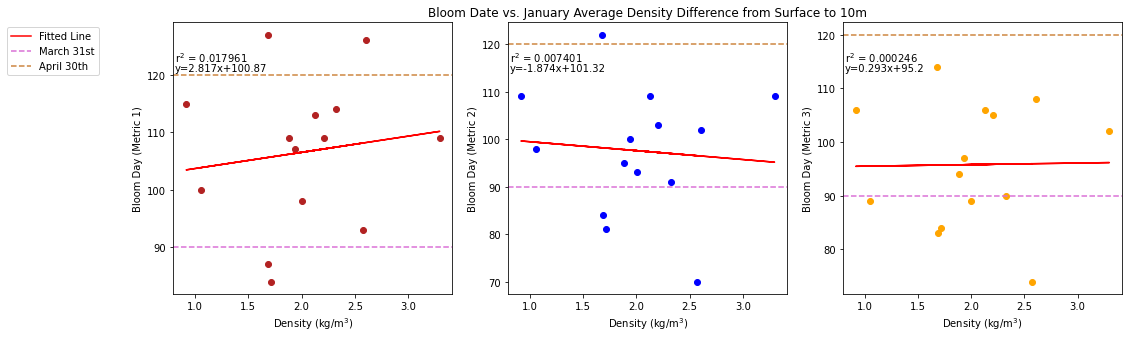

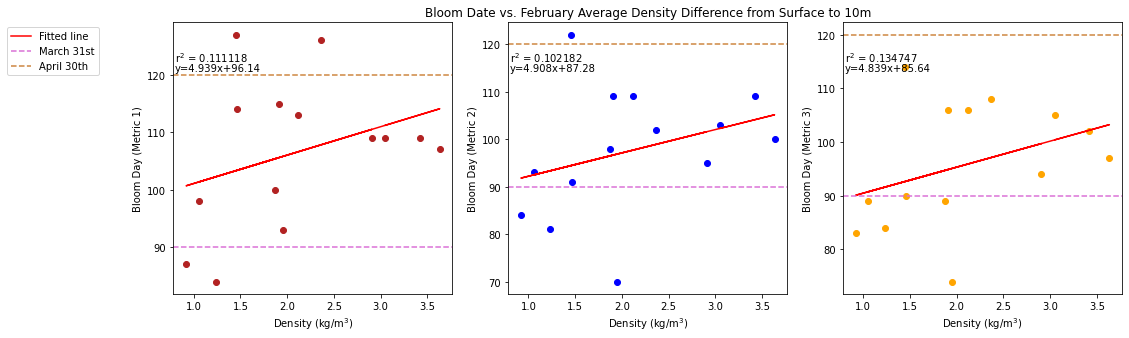

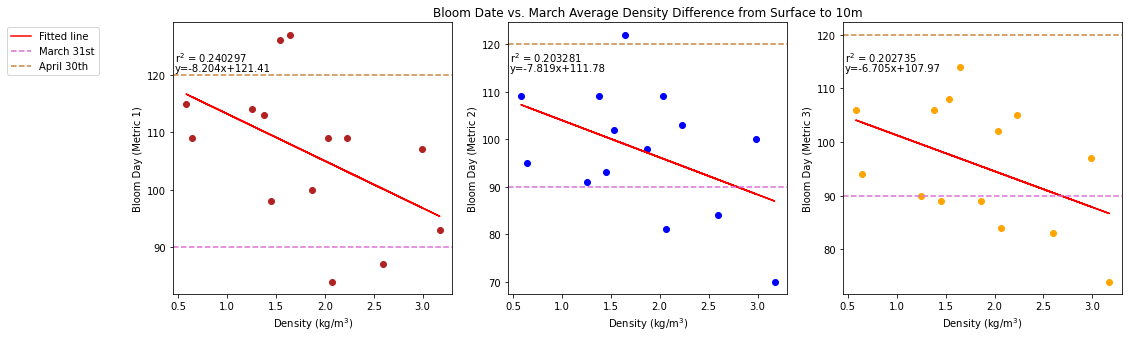

In [11]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
p1=ax.plot(years,densdiff10jan, '-',color='green',label='January Average')
p2=ax.plot(years,densdiff10feb, '-',color='c',label='February Average')
p3=ax.plot(years,densdiff10mar, '-',color='orchid',label='March Average')
ax.set_ylabel('Density (kg/$\mathregular{m^3}$)')
ax.set_xlabel('Year')
ax.set_title('Density difference from surface to 10m by Year')
ax.set_xticks([2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020])
ax.legend(handles=[p1[0],p2[0],p3[0]],bbox_to_anchor=(-0.25, 1.0), loc='upper left')

ax1=ax.twinx()
p4=ax1.plot(years,yearday1, 'o',color='firebrick',label='Metric1')
p5=ax1.plot(years,yearday2, 'o',color='b',label='Metric2')
p6=ax1.plot(years,yearday3, 'o',color='orange',label='Metric3')
ax1.set_ylabel('Year Day')
ax1.legend(handles=[p4[0],p5[0],p6[0]],bbox_to_anchor=(1.05, 1.0), loc='upper left')

# ---------- Jan ---------
fig2,ax2=plt.subplots(1,3,figsize=(17,5))
ax2[0].plot(densdiff10jan,yearday1,'o',color='firebrick')
ax2[0].set_xlabel('Density (kg/$\mathregular{m^3}$)')
ax2[0].set_ylabel('Bloom Day (Metric 1)')
y,r2,m,b=bloomdrivers.reg_r2(densdiff10jan,yearday1)
ax2[0].plot(densdiff10jan, y, 'r', label='Fitted Line')
ax2[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax2[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax2[1].plot(densdiff10jan,yearday2,'o',color='b')
ax2[1].set_xlabel('Density (kg/$\mathregular{m^3}$)')
ax2[1].set_ylabel('Bloom Day (Metric 2)')
y,r2,m,b=bloomdrivers.reg_r2(densdiff10jan,yearday2)
ax2[1].plot(densdiff10jan, y, 'r', label='Fitted line')
ax2[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax2[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax2[2].plot(densdiff10jan,yearday3,'o',color='orange')
ax2[2].set_xlabel('Density (kg/$\mathregular{m^3}$)')
ax2[2].set_ylabel('Bloom Day (Metric 3)')
y,r2,m,b=bloomdrivers.reg_r2(densdiff10jan,yearday3)
ax2[2].plot(densdiff10jan, y, 'r', label='Fitted line')
ax2[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax2[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax2[1].set_title('Bloom Date vs. January Average Density Difference from Surface to 10m')

# ---------- Feb ---------
fig3,ax3=plt.subplots(1,3,figsize=(17,5))
ax3[0].plot(densdiff10feb,yearday1,'o',color='firebrick')
ax3[0].set_xlabel('Density (kg/$\mathregular{m^3}$)')
ax3[0].set_ylabel('Bloom Day (Metric 1)')
y,r2,m,b=bloomdrivers.reg_r2(densdiff10feb,yearday1)
ax3[0].plot(densdiff10feb, y, 'r', label='Fitted line')
ax3[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax3[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax3[1].plot(densdiff10feb,yearday2,'o',color='b')
ax3[1].set_xlabel('Density (kg/$\mathregular{m^3}$)')
ax3[1].set_ylabel('Bloom Day (Metric 2)')
y,r2,m,b=bloomdrivers.reg_r2(densdiff10feb,yearday2)
ax3[1].plot(densdiff10feb, y, 'r', label='Fitted line')
ax3[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax3[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax3[2].plot(densdiff10feb,yearday3,'o',color='orange')
ax3[2].set_xlabel('Density (kg/$\mathregular{m^3}$)')
ax3[2].set_ylabel('Bloom Day (Metric 3)')
y,r2,m,b=bloomdrivers.reg_r2(densdiff10feb,yearday3)
ax3[2].plot(densdiff10feb, y, 'r', label='Fitted line')
ax3[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax3[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax3[1].set_title('Bloom Date vs. February Average Density Difference from Surface to 10m')

# ---------- March ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(densdiff10mar,yearday1,'o',color='firebrick')
ax4[0].set_xlabel('Density (kg/$\mathregular{m^3}$)')
ax4[0].set_ylabel('Bloom Day (Metric 1)')
y,r2,m,b=bloomdrivers.reg_r2(densdiff10mar,yearday1)
ax4[0].plot(densdiff10mar, y, 'r', label='Fitted line')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(densdiff10mar,yearday2,'o',color='b')
ax4[1].set_xlabel('Density (kg/$\mathregular{m^3}$)')
ax4[1].set_ylabel('Bloom Day (Metric 2)')
y,r2,m,b=bloomdrivers.reg_r2(densdiff10mar,yearday2)
ax4[1].plot(densdiff10mar, y, 'r', label='Fitted line')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(densdiff10mar,yearday3,'o',color='orange')
ax4[2].set_xlabel('Density (kg/$\mathregular{m^3}$)')
ax4[2].set_ylabel('Bloom Day (Metric 3)')
y,r2,m,b=bloomdrivers.reg_r2(densdiff10mar,yearday3)
ax4[2].plot(densdiff10mar, y, 'r', label='Fitted line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].set_title('Bloom Date vs. March Average Density Difference from Surface to 10m')

# Jan month lines
ax2[0].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax2[0].axhline(y=120, color='peru', linestyle='--',label='April 30th')
ax2[0].legend(bbox_to_anchor=(-0.25, 1.0))
ax2[1].axhline(y=90, color='orchid', linestyle='--')
ax2[2].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax2[1].axhline(y=120, color='peru', linestyle='--')
ax2[2].axhline(y=120, color='peru', linestyle='--',label='April 30th')
# Feb month lines
ax3[0].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax3[0].axhline(y=120, color='peru', linestyle='--',label='April 30th')
ax3[0].legend(bbox_to_anchor=(-0.25, 1.0))
ax3[1].axhline(y=90, color='orchid', linestyle='--')
ax3[2].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax3[1].axhline(y=120, color='peru', linestyle='--')
ax3[2].axhline(y=120, color='peru', linestyle='--',label='April 30th')
# March month lines
ax4[0].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax4[0].axhline(y=120, color='peru', linestyle='--',label='April 30th')
ax4[0].legend(bbox_to_anchor=(-0.25, 1.0))
ax4[1].axhline(y=90, color='orchid', linestyle='--')
ax4[2].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax4[1].axhline(y=120, color='peru', linestyle='--')
ax4[2].axhline(y=120, color='peru', linestyle='--',label='April 30th')

### Monthly average eddy diffusivity in top 15m (January-March)

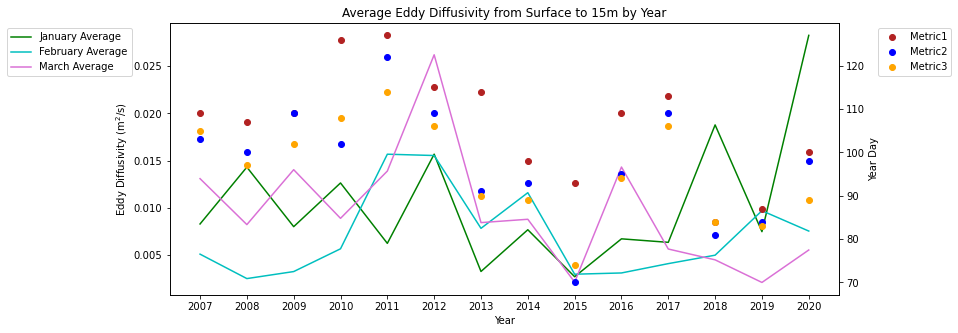

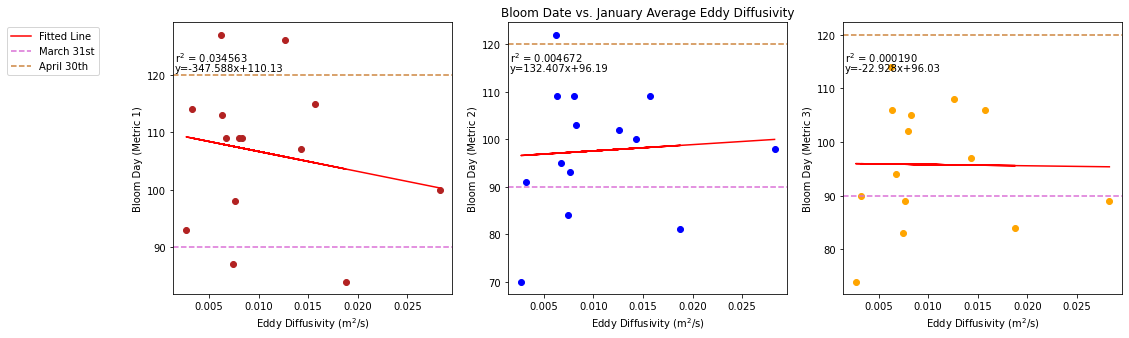

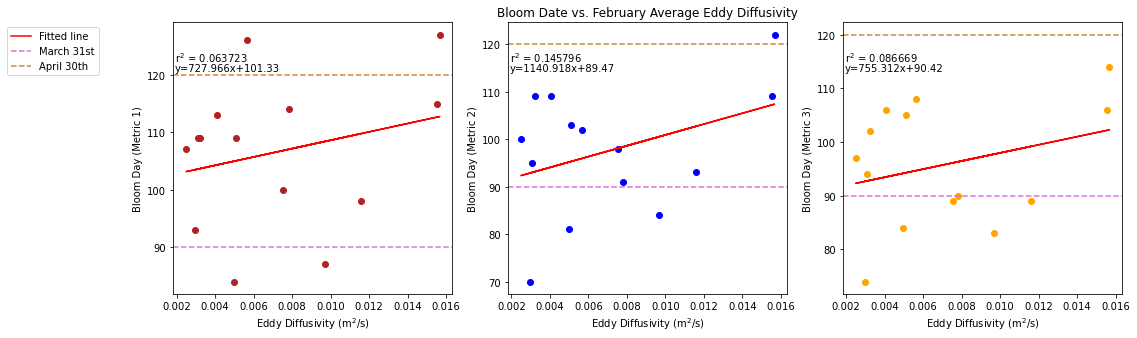

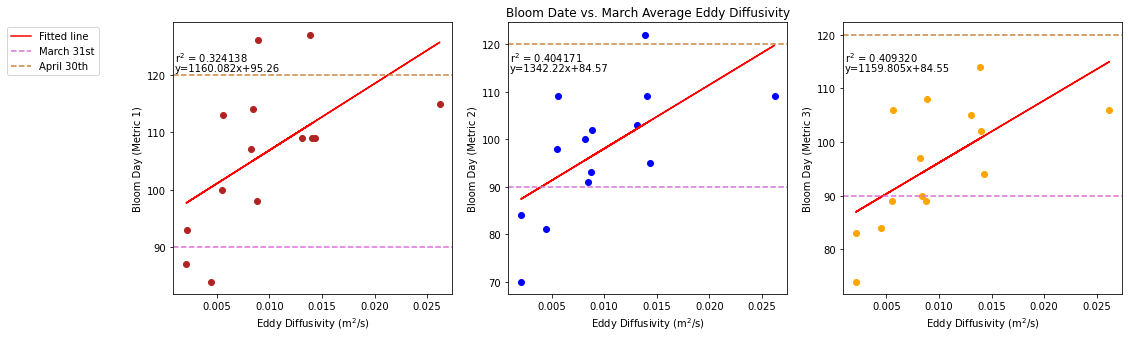

In [11]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
p1=ax.plot(years,eddy15jan, '-',color='green',label='January Average')
p2=ax.plot(years,eddy15feb, '-',color='c',label='February Average')
p3=ax.plot(years,eddy15mar, '-',color='orchid',label='March Average')
ax.set_ylabel('Eddy Diffusivity ($\mathregular{m^2}$/s)')
ax.set_xlabel('Year')
ax.set_title('Average Eddy Diffusivity from Surface to 15m by Year')
ax.set_xticks([2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020])
ax.legend(handles=[p1[0],p2[0],p3[0]],bbox_to_anchor=(-0.25, 1.0), loc='upper left')

ax1=ax.twinx()
p4=ax1.plot(years,yearday1, 'o',color='firebrick',label='Metric1')
p5=ax1.plot(years,yearday2, 'o',color='b',label='Metric2')
p6=ax1.plot(years,yearday3, 'o',color='orange',label='Metric3')
ax1.set_ylabel('Year Day')
ax1.legend(handles=[p4[0],p5[0],p6[0]],bbox_to_anchor=(1.05, 1.0), loc='upper left')

# ---------- Jan ---------
fig2,ax2=plt.subplots(1,3,figsize=(17,5))
ax2[0].plot(eddy15jan,yearday1,'o',color='firebrick')
ax2[0].set_xlabel('Eddy Diffusivity ($\mathregular{m^2}$/s)')
ax2[0].set_ylabel('Bloom Day (Metric 1)')
y,r2,m,b=bloomdrivers.reg_r2(eddy15jan,yearday1)
ax2[0].plot(eddy15jan, y, 'r', label='Fitted Line')
ax2[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax2[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax2[1].plot(eddy15jan,yearday2,'o',color='b')
ax2[1].set_xlabel('Eddy Diffusivity ($\mathregular{m^2}$/s)')
ax2[1].set_ylabel('Bloom Day (Metric 2)')
y,r2,m,b=bloomdrivers.reg_r2(eddy15jan,yearday2)
ax2[1].plot(eddy15jan, y, 'r', label='Fitted line')
ax2[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax2[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax2[2].plot(eddy15jan,yearday3,'o',color='orange')
ax2[2].set_xlabel('Eddy Diffusivity ($\mathregular{m^2}$/s)')
ax2[2].set_ylabel('Bloom Day (Metric 3)')
y,r2,m,b=bloomdrivers.reg_r2(eddy15jan,yearday3)
ax2[2].plot(eddy15jan, y, 'r', label='Fitted line')
ax2[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax2[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax2[1].set_title('Bloom Date vs. January Average Eddy Diffusivity')

# ---------- Feb ---------
fig3,ax3=plt.subplots(1,3,figsize=(17,5))
ax3[0].plot(eddy15feb,yearday1,'o',color='firebrick')
ax3[0].set_xlabel('Eddy Diffusivity ($\mathregular{m^2}$/s)')
ax3[0].set_ylabel('Bloom Day (Metric 1)')
y,r2,m,b=bloomdrivers.reg_r2(eddy15feb,yearday1)
ax3[0].plot(eddy15feb, y, 'r', label='Fitted line')
ax3[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax3[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax3[1].plot(eddy15feb,yearday2,'o',color='b')
ax3[1].set_xlabel('Eddy Diffusivity ($\mathregular{m^2}$/s)')
ax3[1].set_ylabel('Bloom Day (Metric 2)')
y,r2,m,b=bloomdrivers.reg_r2(eddy15feb,yearday2)
ax3[1].plot(eddy15feb, y, 'r', label='Fitted line')
ax3[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax3[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax3[2].plot(eddy15feb,yearday3,'o',color='orange')
ax3[2].set_xlabel('Eddy Diffusivity ($\mathregular{m^2}$/s)')
ax3[2].set_ylabel('Bloom Day (Metric 3)')
y,r2,m,b=bloomdrivers.reg_r2(eddy15feb,yearday3)
ax3[2].plot(eddy15feb, y, 'r', label='Fitted line')
ax3[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax3[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax3[1].set_title('Bloom Date vs. February Average Eddy Diffusivity')

# ---------- March ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(eddy15mar,yearday1,'o',color='firebrick')
ax4[0].set_xlabel('Eddy Diffusivity ($\mathregular{m^2}$/s)')
ax4[0].set_ylabel('Bloom Day (Metric 1)')
y,r2,m,b=bloomdrivers.reg_r2(eddy15mar,yearday1)
ax4[0].plot(eddy15mar, y, 'r', label='Fitted line')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(eddy15mar,yearday2,'o',color='b')
ax4[1].set_xlabel('Eddy Diffusivity ($\mathregular{m^2}$/s)')
ax4[1].set_ylabel('Bloom Day (Metric 2)')
y,r2,m,b=bloomdrivers.reg_r2(eddy15mar,yearday2)
ax4[1].plot(eddy15mar, y, 'r', label='Fitted line')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(eddy15mar,yearday3,'o',color='orange')
ax4[2].set_xlabel('Eddy Diffusivity ($\mathregular{m^2}$/s)')
ax4[2].set_ylabel('Bloom Day (Metric 3)')
y,r2,m,b=bloomdrivers.reg_r2(eddy15mar,yearday3)
ax4[2].plot(eddy15mar, y, 'r', label='Fitted line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].set_title('Bloom Date vs. March Average Eddy Diffusivity')

# Jan month lines
ax2[0].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax2[0].axhline(y=120, color='peru', linestyle='--',label='April 30th')
ax2[0].legend(bbox_to_anchor=(-0.25, 1.0))
ax2[1].axhline(y=90, color='orchid', linestyle='--')
ax2[2].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax2[1].axhline(y=120, color='peru', linestyle='--')
ax2[2].axhline(y=120, color='peru', linestyle='--',label='April 30th')
# Feb month lines
ax3[0].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax3[0].axhline(y=120, color='peru', linestyle='--',label='April 30th')
ax3[0].legend(bbox_to_anchor=(-0.25, 1.0))
ax3[1].axhline(y=90, color='orchid', linestyle='--')
ax3[2].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax3[1].axhline(y=120, color='peru', linestyle='--')
ax3[2].axhline(y=120, color='peru', linestyle='--',label='April 30th')
# March month lines
ax4[0].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax4[0].axhline(y=120, color='peru', linestyle='--',label='April 30th')
ax4[0].legend(bbox_to_anchor=(-0.25, 1.0))
ax4[1].axhline(y=90, color='orchid', linestyle='--')
ax4[2].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax4[1].axhline(y=120, color='peru', linestyle='--')
ax4[2].axhline(y=120, color='peru', linestyle='--',label='April 30th')

### Monthly average eddy diffusivity in top 30m (January-March)

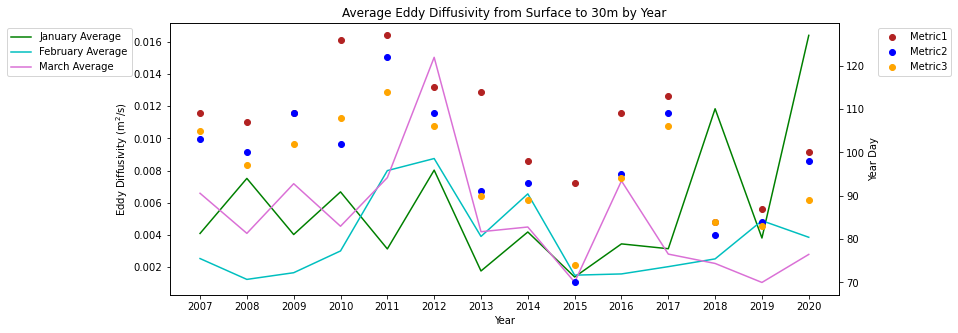

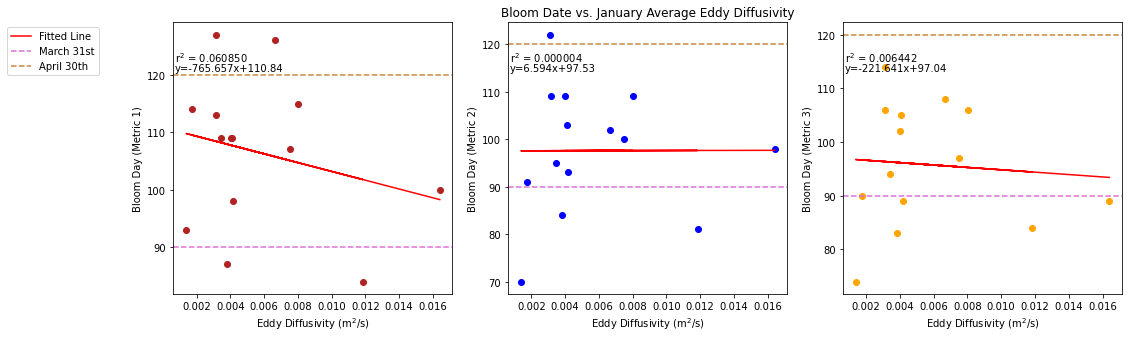

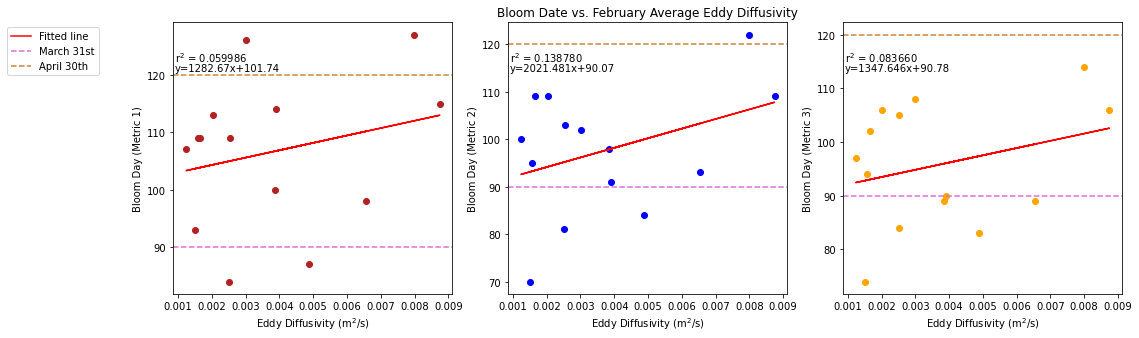

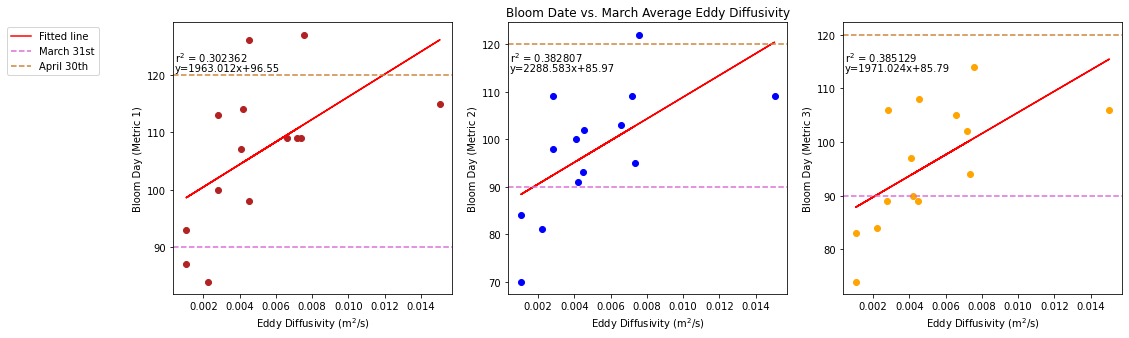

In [12]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
p1=ax.plot(years,eddy30jan, '-',color='green',label='January Average')
p2=ax.plot(years,eddy30feb, '-',color='c',label='February Average')
p3=ax.plot(years,eddy30mar, '-',color='orchid',label='March Average')
ax.set_ylabel('Eddy Diffusivity ($\mathregular{m^2}$/s)')
ax.set_xlabel('Year')
ax.set_title('Average Eddy Diffusivity from Surface to 30m by Year')
ax.set_xticks([2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020])
ax.legend(handles=[p1[0],p2[0],p3[0]],bbox_to_anchor=(-0.25, 1.0), loc='upper left')

ax1=ax.twinx()
p4=ax1.plot(years,yearday1, 'o',color='firebrick',label='Metric1')
p5=ax1.plot(years,yearday2, 'o',color='b',label='Metric2')
p6=ax1.plot(years,yearday3, 'o',color='orange',label='Metric3')
ax1.set_ylabel('Year Day')
ax1.legend(handles=[p4[0],p5[0],p6[0]],bbox_to_anchor=(1.05, 1.0), loc='upper left')

# ---------- Jan ---------
fig2,ax2=plt.subplots(1,3,figsize=(17,5))
ax2[0].plot(eddy30jan,yearday1,'o',color='firebrick')
ax2[0].set_xlabel('Eddy Diffusivity ($\mathregular{m^2}$/s)')
ax2[0].set_ylabel('Bloom Day (Metric 1)')
y,r2,m,b=bloomdrivers.reg_r2(eddy30jan,yearday1)
ax2[0].plot(eddy30jan, y, 'r', label='Fitted Line')
ax2[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax2[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax2[1].plot(eddy30jan,yearday2,'o',color='b')
ax2[1].set_xlabel('Eddy Diffusivity ($\mathregular{m^2}$/s)')
ax2[1].set_ylabel('Bloom Day (Metric 2)')
y,r2,m,b=bloomdrivers.reg_r2(eddy30jan,yearday2)
ax2[1].plot(eddy30jan, y, 'r', label='Fitted line')
ax2[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax2[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax2[2].plot(eddy30jan,yearday3,'o',color='orange')
ax2[2].set_xlabel('Eddy Diffusivity ($\mathregular{m^2}$/s)')
ax2[2].set_ylabel('Bloom Day (Metric 3)')
y,r2,m,b=bloomdrivers.reg_r2(eddy30jan,yearday3)
ax2[2].plot(eddy30jan, y, 'r', label='Fitted line')
ax2[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax2[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax2[1].set_title('Bloom Date vs. January Average Eddy Diffusivity')

# ---------- Feb ---------
fig3,ax3=plt.subplots(1,3,figsize=(17,5))
ax3[0].plot(eddy30feb,yearday1,'o',color='firebrick')
ax3[0].set_xlabel('Eddy Diffusivity ($\mathregular{m^2}$/s)')
ax3[0].set_ylabel('Bloom Day (Metric 1)')
y,r2,m,b=bloomdrivers.reg_r2(eddy30feb,yearday1)
ax3[0].plot(eddy30feb, y, 'r', label='Fitted line')
ax3[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax3[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax3[1].plot(eddy30feb,yearday2,'o',color='b')
ax3[1].set_xlabel('Eddy Diffusivity ($\mathregular{m^2}$/s)')
ax3[1].set_ylabel('Bloom Day (Metric 2)')
y,r2,m,b=bloomdrivers.reg_r2(eddy30feb,yearday2)
ax3[1].plot(eddy30feb, y, 'r', label='Fitted line')
ax3[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax3[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax3[2].plot(eddy30feb,yearday3,'o',color='orange')
ax3[2].set_xlabel('Eddy Diffusivity ($\mathregular{m^2}$/s)')
ax3[2].set_ylabel('Bloom Day (Metric 3)')
y,r2,m,b=bloomdrivers.reg_r2(eddy30feb,yearday3)
ax3[2].plot(eddy30feb, y, 'r', label='Fitted line')
ax3[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2,transform=ax.transAxes)
ax3[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax3[1].set_title('Bloom Date vs. February Average Eddy Diffusivity')

# ---------- March ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(eddy30mar,yearday1,'o',color='firebrick')
ax4[0].set_xlabel('Eddy Diffusivity ($\mathregular{m^2}$/s)')
ax4[0].set_ylabel('Bloom Day (Metric 1)')
y,r2,m,b=bloomdrivers.reg_r2(eddy30mar,yearday1)
ax4[0].plot(eddy30mar, y, 'r', label='Fitted line')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(eddy30mar,yearday2,'o',color='b')
ax4[1].set_xlabel('Eddy Diffusivity ($\mathregular{m^2}$/s)')
ax4[1].set_ylabel('Bloom Day (Metric 2)')
y,r2,m,b=bloomdrivers.reg_r2(eddy30mar,yearday2)
ax4[1].plot(eddy30mar, y, 'r', label='Fitted line')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(eddy30mar,yearday3,'o',color='orange')
ax4[2].set_xlabel('Eddy Diffusivity ($\mathregular{m^2}$/s)')
ax4[2].set_ylabel('Bloom Day (Metric 3)')
y,r2,m,b=bloomdrivers.reg_r2(eddy30mar,yearday3)
ax4[2].plot(eddy30mar, y, 'r', label='Fitted line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].set_title('Bloom Date vs. March Average Eddy Diffusivity')

# Jan month lines
ax2[0].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax2[0].axhline(y=120, color='peru', linestyle='--',label='April 30th')
ax2[0].legend(bbox_to_anchor=(-0.25, 1.0))
ax2[1].axhline(y=90, color='orchid', linestyle='--')
ax2[2].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax2[1].axhline(y=120, color='peru', linestyle='--')
ax2[2].axhline(y=120, color='peru', linestyle='--',label='April 30th')
# Feb month lines
ax3[0].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax3[0].axhline(y=120, color='peru', linestyle='--',label='April 30th')
ax3[0].legend(bbox_to_anchor=(-0.25, 1.0))
ax3[1].axhline(y=90, color='orchid', linestyle='--')
ax3[2].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax3[1].axhline(y=120, color='peru', linestyle='--')
ax3[2].axhline(y=120, color='peru', linestyle='--',label='April 30th')
# March month lines
ax4[0].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax4[0].axhline(y=120, color='peru', linestyle='--',label='April 30th')
ax4[0].legend(bbox_to_anchor=(-0.25, 1.0))
ax4[1].axhline(y=90, color='orchid', linestyle='--')
ax4[2].axhline(y=90, color='orchid', linestyle='--',label='March 31st')
ax4[1].axhline(y=120, color='peru', linestyle='--')
ax4[2].axhline(y=120, color='peru', linestyle='--',label='April 30th')

In [13]:
# January dataframe
dfjan=pd.DataFrame({'metric1':yearday1, 'metric2':yearday2, 'metric3':yearday3,'halocline':halojan,'turbocline':turbojan,
                    'eddy15jan':eddy15jan,'eddy30jan':eddy30jan,'densdiff5jan':densdiff5jan,'densdiff10jan':densdiff10jan,
                    'densdiff15jan':densdiff15jan,'densdiff20jan':densdiff20jan,'densdiff25jan':densdiff25jan,'densdiff30jan':densdiff30jan})

# February dataframe
dffeb=pd.DataFrame({'metric1':yearday1, 'metric2':yearday2, 'metric3':yearday3,'halocline':halofeb,'turbocline':turbofeb,
                    'eddy15feb':eddy15feb,'eddy30feb':eddy30feb,'densdiff5feb':densdiff5feb,'densdiff10feb':densdiff10feb,
                    'densdiff15feb':densdiff15feb,'densdiff20feb':densdiff20feb,'densdiff25feb':densdiff25feb,'densdiff30feb':densdiff30feb})
# March dataframe
dfmar=pd.DataFrame({'metric1':yearday1, 'metric2':yearday2, 'metric3':yearday3,'halocline':halomar,'turbocline':turbomar,
                    'eddy15mar':eddy15mar,'eddy30mar':eddy30mar,'densdiff5mar':densdiff5mar,'densdiff10mar':densdiff10mar,
                    'densdiff15mar':densdiff15mar,'densdiff20mar':densdiff20mar,'densdiff25mar':densdiff25mar,'densdiff30mar':densdiff30mar})

### Correlation matrix for January Values


<AxesSubplot:>

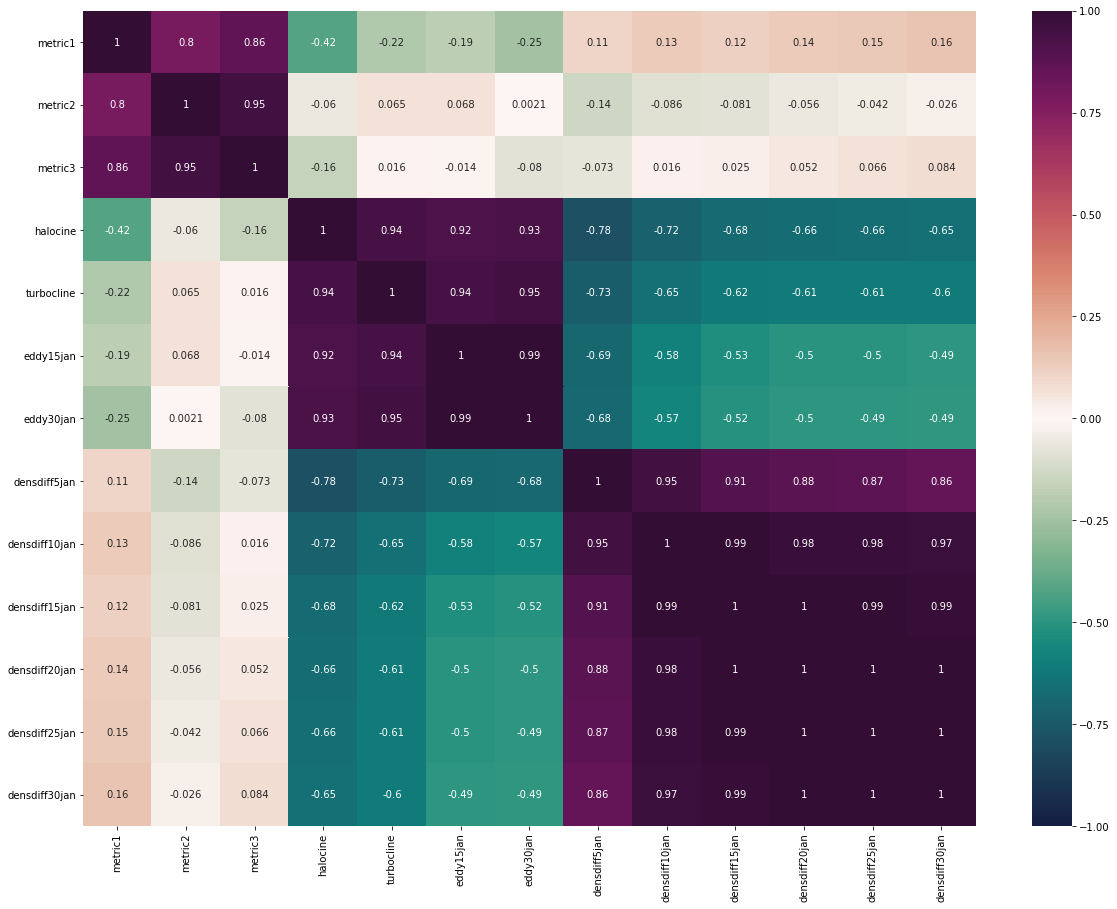

In [14]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfjan.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

### Correlation matrix for February Values

<AxesSubplot:>

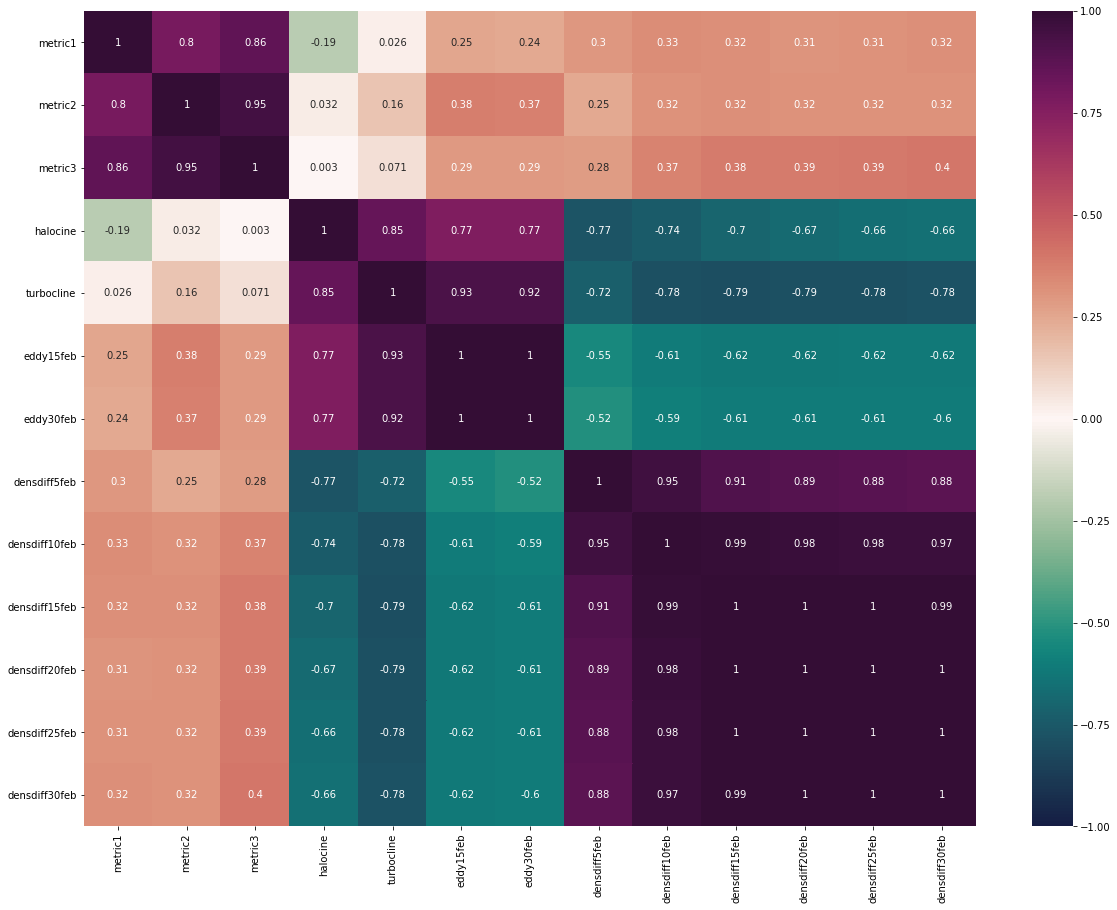

In [15]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dffeb.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

### Correlation matrix for March Values

<AxesSubplot:>

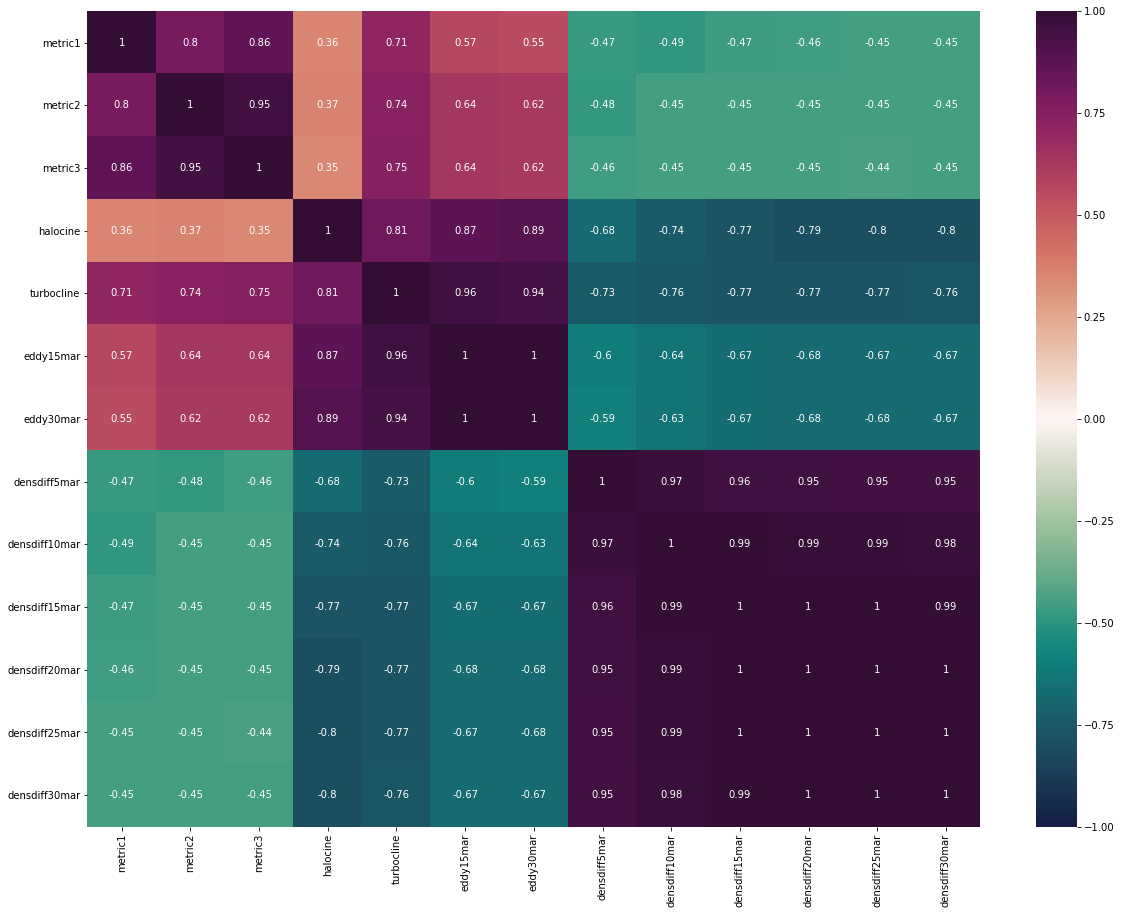

In [16]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfmar.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)